In [85]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

In [328]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0  # Assume zero effect at start
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # chain rule for addition
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): # other -  self
        return self - other
    
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # chain rule for multiplication
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other): # self ** other
        assert isinstance(other, (int, float)), 'only supporting int/float powers at the moment'
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    
    def __truediv__(self, other): # self/other
        return self * other**-1
            

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        return node 

In [329]:
a = Value(2.0)
b = Value(4.0)
# a / b
a - b

Value(data = -2.0)

In [330]:
def trace(root):
    # builds a set of nodes and edge in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [331]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it 
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    # for n in nodes:
    #     dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
    #     if n._op:
    #         dot.node(name=str(id(n)) + n._op, label=n._op)
    #         dot.edge(str(id(n)) + n._op, str(id(n)))
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2 
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

            
    return dot
                

In [332]:
# reset_graph()
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813835870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# tanh is squashing n
o = n.tanh(); o.label = 'o'

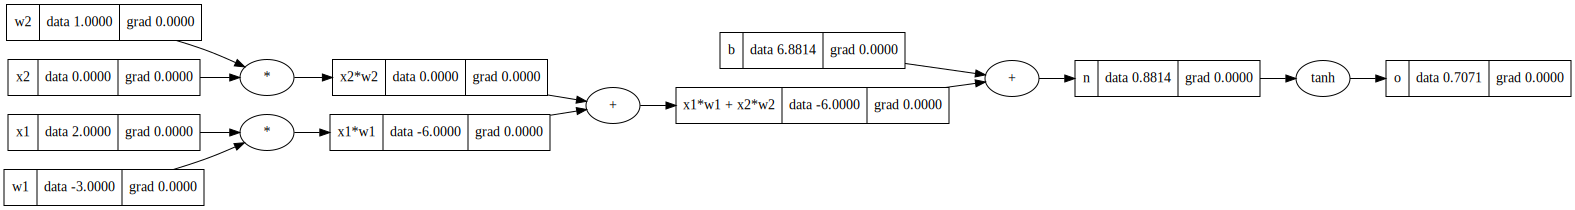

In [333]:
draw_dot(o)

In [334]:
o.backward()

Value(data = 6.881383587019543)

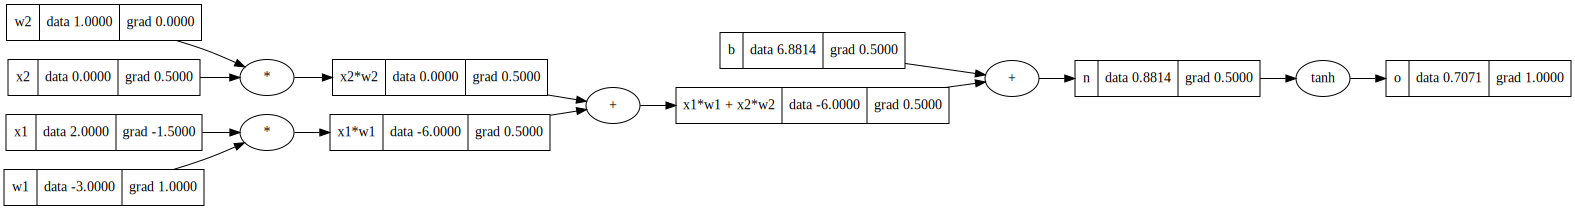

In [335]:
draw_dot(o)

In [336]:
# reset_graph()
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813835870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# tanh is squashing n
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e - 1)/(e + 1)  # Equivalent to tanh

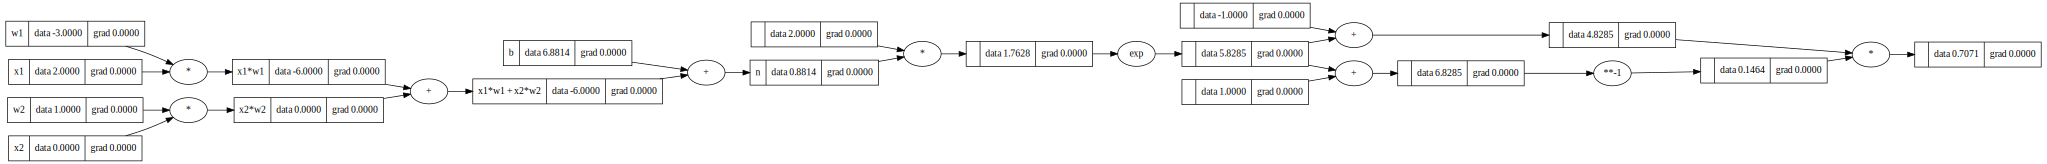

In [337]:
draw_dot(o)

In [338]:
o.backward()

Value(data = 1)

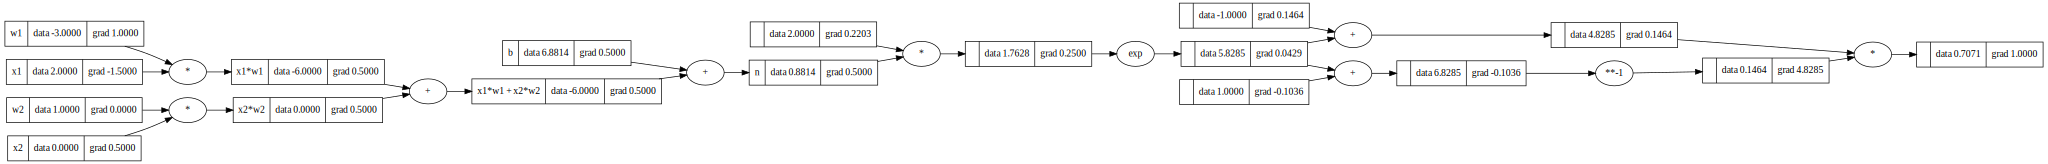

In [339]:
draw_dot(o)

In [340]:
import torch

In [341]:
# Verify that PyTorch is calculating the same gradients
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Define a neuron

In [355]:
class Neuron:
    
    def __init__(self, nin):
        # nin is the number of inputs into the neuron
        # Initialise random weights for each of these inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        # The bias b is a measure of the trigger happiness of the neuron
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # Activation of neuron is the sum of the weights
        # w * x + b  where (w*x) is a dot product
        # Forward pass
        # zip takes 2 iterators and creates a new iterator consisting of the tuples of the original iterators
        
        act = sum((wi*xi for wi, xi in list(zip(self.w, x))), self.b) 
        out = act.tanh()
        return out
    
    # Collect all parameters of nn in one array
    def parameters(self):
        return self.w + [self.b]
    
# Define a layer class that takes the number of neurons you want in the layer as nout
class Layer:
    
    def __init__(self, nin, nout):
        # Create a list of indendently initiated neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        # Return a single value if there is just one output
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neuron:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        
# Define a multi-layer perceptron class that takes the number inputs (nin) and a 
# list that defines the sizes of all the layers required
          
class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
          x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# x = [2.0, 3.0]
# n = Neuron(2)
# n(x)

# l = Layer(2, 4)
# l(x)

In [356]:
# Create an MLP with 3 inputs, 2 layers of 4 neurons and a single output unit
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.7349539574212258)

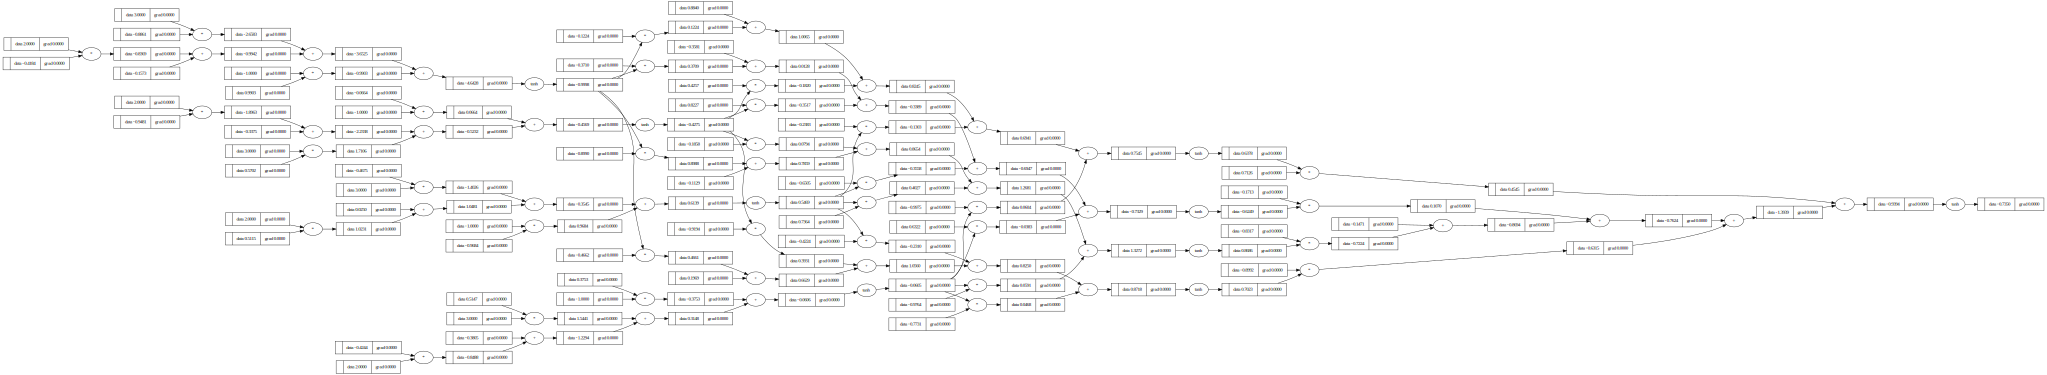

In [359]:
draw_dot(n(x))

## Evaluate loss as mean squared error

In [360]:
# Inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data = -0.7349539574212258),
 Value(data = -0.7508505532645661),
 Value(data = 0.2017053130787441),
 Value(data = -0.7582325714892026)]

In [361]:
loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
loss
# sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

Value(data = 7.607618116107362)

In [362]:
loss.backward()

Value(data = -0.9684371600071875)

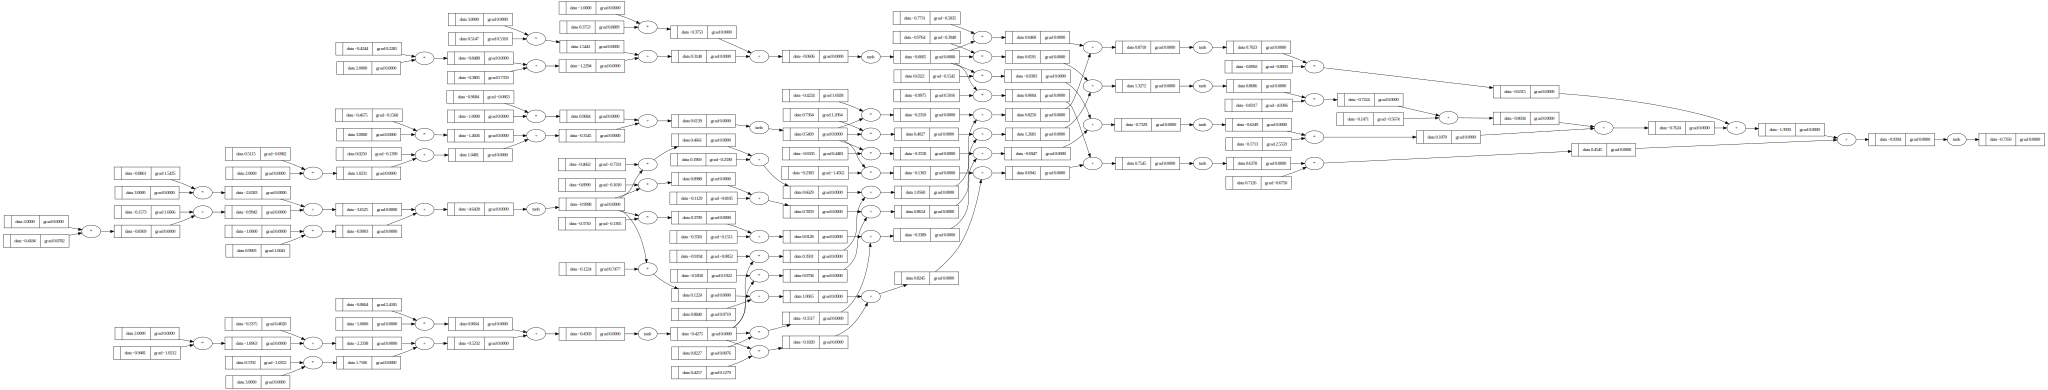

In [363]:
draw_dot(n(x))

In [382]:
n.layers[0].neurons[0].w[0].grad

0.8781712669593544

In [383]:
n.layers[0].neurons[0].w[0].data

-0.4184422462808275

In [379]:
# Number of parameters in nn
len(n.parameters())

41

In [380]:
# All weights and biases in neural network
n.parameters()

[Value(data = -0.4184422462808275),
 Value(data = -0.8861114494430467),
 Value(data = 0.9903126370737929),
 Value(data = -0.15731826485693112),
 Value(data = -0.9481390748654841),
 Value(data = 0.5702008697356449),
 Value(data = -0.06635111653765269),
 Value(data = -0.33754892014938),
 Value(data = 0.5115377474998437),
 Value(data = -0.4675220074019184),
 Value(data = -0.9684371600071875),
 Value(data = 0.024978371937084187),
 Value(data = -0.42441754646366747),
 Value(data = 0.5147065604564196),
 Value(data = 0.37533862355272385),
 Value(data = -0.38053399443350444),
 Value(data = -0.8989804515209194),
 Value(data = -0.18582159593820657),
 Value(data = 0.7364201072959269),
 Value(data = -0.9763802034067925),
 Value(data = -0.11286756777988449),
 Value(data = -0.37096812958250136),
 Value(data = 0.8226742312363571),
 Value(data = -0.6505150515144882),
 Value(data = 0.6321666394113126),
 Value(data = -0.3581115812763842),
 Value(data = -0.46616341307802545),
 Value(data = -0.91940441686

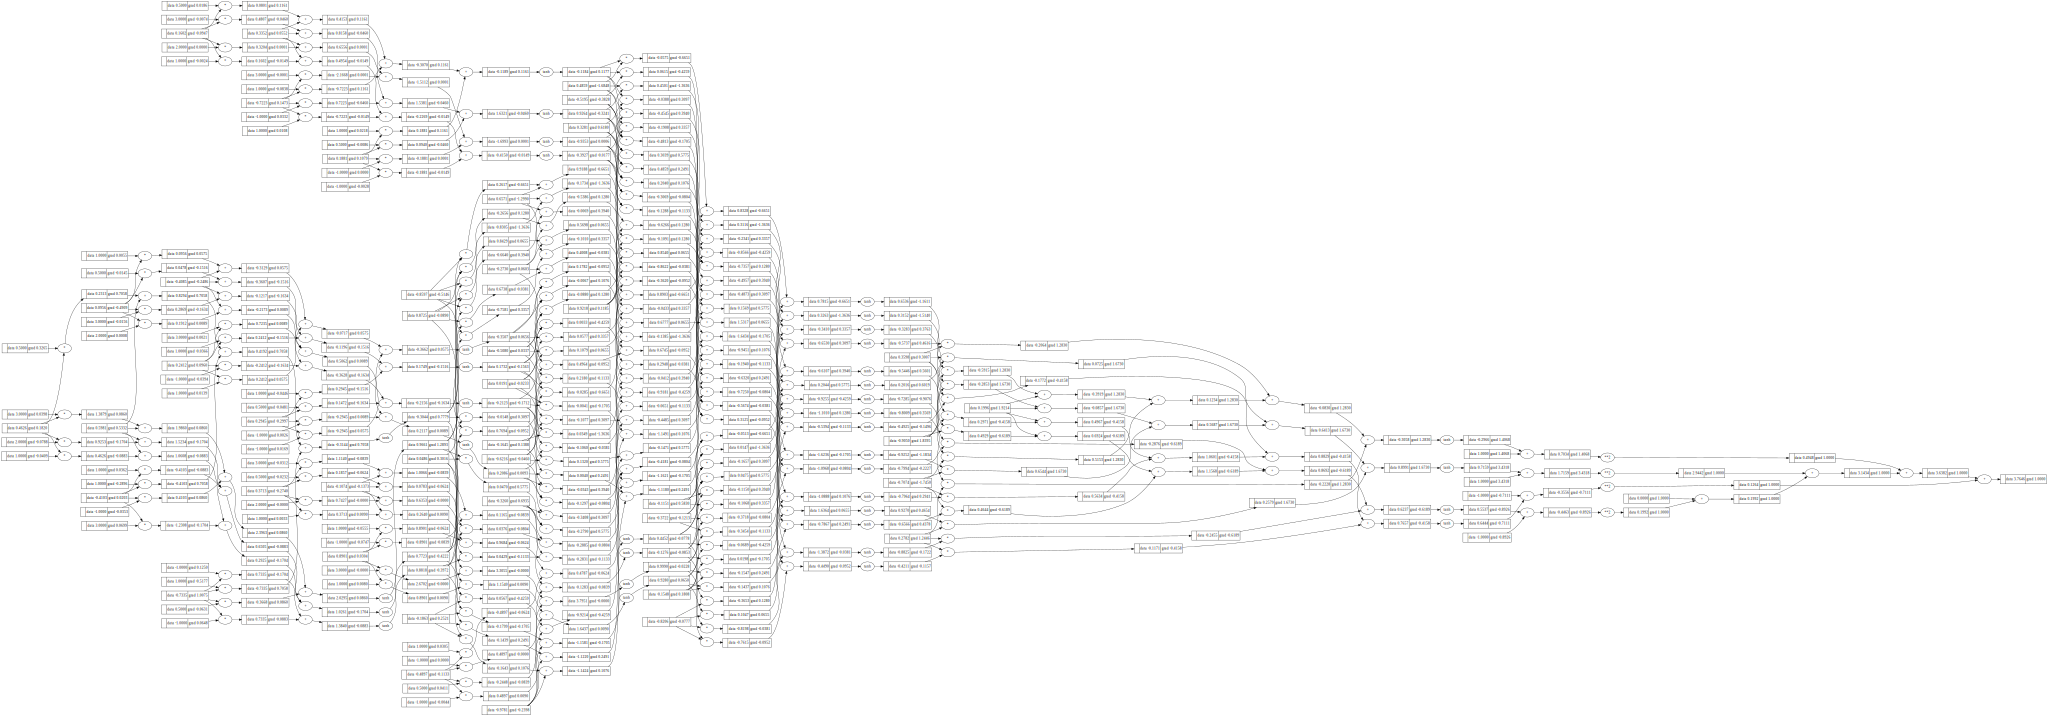

In [354]:
draw_dot(loss)

In [384]:
n.layers[0].neurons[0].w[0].data

-0.4184422462808275

In [385]:
n.layers[0].neurons[0].w[0].grad

0.8781712669593544

In [386]:
# Update weights
for p in n.parameters():
    p.data += -0.1 * p.grad

In [387]:
# Predict that n.layers[0].neurons[0].w[0].data will get more negative to reduce the loss
n.layers[0].neurons[0].w[0].data

-0.5062593729767629

In [ ]:
# Value(data = 7.607618116107362)

## Neural Network training loop

In [625]:
# Reinitialise the NN
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.14637988139647304)

In [626]:
# Inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data = -0.14637988139647304),
 Value(data = 0.8653521555804128),
 Value(data = 0.7199998078083594),
 Value(data = -0.4264444651421772)]

In [655]:
for k in range(10):

    # forward pass and evaluate the loss
    ypred = [n(x) for x in xs]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
    loss
    
    # backward pass
    # reset the gradients to zero because they are accumulating
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update weights (stochastic descent gradient update)
    for p in n.parameters():
        p.data += -0.03 * p.grad
        
    # print(k, loss.data)
        

In [656]:
ypred

[Value(data = 0.9852997364776405),
 Value(data = -0.986307449735353),
 Value(data = -0.9659339753998849),
 Value(data = 0.9688995229862644)]